In [1]:
from VariationalBayes.Models.LinearMixedModel.ConjugateModel import \
    get_base_prior_parameters, get_base_parameters, get_base_moment_parameters, set_moments, \
    LMMDataCache, CoordinateAscentUpdater, KLWrapper, MomentWrapper

from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy as asp
import scipy as sp

import copy
from scipy import optimize

import time

In [54]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

# Simulate data
N = 100     # observations per group
K = 10      # dimension of regressors
NG = 3000      # number of groups

# Generate data
NObs = NG * N
true_beta = np.array(range(K))
true_beta = true_beta - np.mean(true_beta)
true_y_info = 1.0

true_mu = 1.0
true_mu_info = 40.0
true_u_sufficient = np.random.normal(true_mu, 1 / np.sqrt(true_mu_info), NG)
true_u_ancillary = true_u_sufficient - true_mu

x_mat = np.random.random(K * NObs).reshape(NObs, K) - 0.5
x_rot = np.full((K, K), 0.5)
for k in range(K):
    x_rot[k, k] = 1.0
x_mat = np.matmul(x_mat, x_rot)

y_g_vec = np.array([ g for g in range(NG) for n in range(N) ])
true_mean = np.matmul(x_mat, true_beta) + true_u_sufficient[y_g_vec]
y_vec = np.random.normal(true_mean, 1 / np.sqrt(true_y_info), NG * N)

print N * NG

300000


In [55]:
# Whether or not you are optimizing a sufficient or ancillary model.
sufficient = True

prior_par = get_base_prior_parameters(K)
lmm_par = get_base_parameters(K, NG, sufficient=sufficient)
moment_par = get_base_moment_parameters(K, NG, sufficient=sufficient)
data_cache = LMMDataCache(x_mat, y_vec, y_g_vec)

set_moments(lmm_par, moment_par)
init_moment_par = copy.deepcopy(moment_par)
init_par_vec = lmm_par.get_free()

moment_indices = copy.deepcopy(moment_par)
moment_indices.set_vector(np.array(range(moment_indices.vector_size())))

In [57]:
# Perform coordinate ascent.
ca_updater = CoordinateAscentUpdater(init_moment_par, data_cache, prior_par, sufficient=sufficient)

ca_time = time.time()
tol = 1e-9
delta = float('inf')
iter = 0
while delta > tol or iter < 100:
# while iter < 100:
    iter += 1
    delta = ca_updater.update()
    if iter % 30 == 0:
        print delta
ca_time = time.time() - ca_time

ca_moment_par_opt = copy.deepcopy(ca_updater.moment_par)

print 'Coordinate ascent time (in seconds):'
print ca_time

2.46004294713e-07
5.43909361994e-12
3.3078817463e-12
Coordinate ascent time (in seconds):
0.701740026474


In [58]:
kl_wrapper = KLWrapper(lmm_par, moment_par, prior_par, x_mat, y_vec, y_g_vec, sufficient=sufficient)
print kl_wrapper.kl(init_par_vec)

import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.kl(init_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: kl_wrapper.kl_grad(init_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: kl_wrapper.kl_hvp(init_par_vec, init_par_vec + 1), number=time_num) / time_num

1204673.23642
Function time:
0.000977492332458
Grad time:
0.00707590579987
Hessian vector product time:
0.0172959089279


In [59]:
# Optimize.
vb_time = time.time()

print 'Running Newton Trust Region'
trust_init = copy.deepcopy(init_par_vec)
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.kl(par, verbose=True),
    trust_init, method='trust-ncg', jac=kl_wrapper.kl_grad, hessp=kl_wrapper.kl_hvp,
    tol=1e-6, options={'maxiter': 500, 'disp': True, 'gtol': 1e-9 })

vb_time = time.time() - vb_time

lmm_par_opt = copy.deepcopy(lmm_par)
lmm_par_opt.set_free(vb_opt.x)

moment_par_opt = copy.deepcopy(moment_par)
set_moments(lmm_par_opt, moment_par_opt)

print 'trust region time (in seconds): %f' %  vb_time

Running Newton Trust Region
1204673.23642
740767.517613
623900.898655
518510.356939
438133.616603
396066.005683
369183.576375
342848.029283
332039.757897
330848.175981
316330.660263
315022.860837
298837.357408
298626.722116
275071.128119
269402.533101
264101.306294
263947.611029
270856.158667
252370.953423
248664.191869
230685.404469
226550.501819
224454.482606
201237.027722
200040.260493
197726.567554
196691.597949
166838.398866
165245.35029
164908.45742
162225.152187
162197.274871
152115.892377
151980.957886
151969.860512
149297.580995
149288.256071
149285.748889
148774.947481
148774.51267
148773.189936
148736.508134
148736.505205
148736.501989
148736.106729
148736.106729
148733.176607
148732.297265
148732.218105
148732.135933
154834.494378
148732.076358
148731.889838
148731.876545
148731.874878
148731.668514
148731.531249
148731.514938
148731.108055
148731.081416
148731.081144
148731.073762
148730.942434
148730.933668
148730.330342
148730.327035
148730.326299
148729.99325
148729.977

In [61]:
# Make sure the coordinate ascent and trust region are close
moment_diff = np.sum(np.abs(ca_moment_par_opt.get_vector() - moment_par_opt.get_vector()))

print kl_wrapper.kl(vb_opt.x)

print 'total moment difference: %f' % moment_diff
print 'trust region seconds: %f' % vb_time
print 'coordinate ascent seconds: %f' % ca_time

148725.82141
total moment difference: 0.000000
trust region seconds: 95.063684
coordinate ascent seconds: 0.701740


In [ ]:
# Get the gamma parameters.
# rate = shape / e
# e_log = sp.special.digamma(shape) - np.log(shape / e)
#       = sp.special.digamma(shape) - np.log(shape) + np.log(e) =>
# e_log - np.log(e) = sp.special.digamma(shape) - np.log(shape)
# Solving for shape gives an unstable fixed point algorithm, but this trick seems to work
# if you start near the correct answer.

print kl_wrapper.kl(vb_opt.x)

def get_gamma_par_from_moments(e, e_log):
    def fp_func(shape):
        return shape * (sp.special.digamma(shape) - np.log(shape)) / (e_log - np.log(e))

    shape_est = sp.optimize.fixed_point(fp_func, 10.)
    rate_est = shape_est / e

    return shape_est, rate_est

shape_est, rate_est = get_gamma_par_from_moments(e, e_log)


--------------- beta:

[-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]
[-4.49507599 -3.48326698 -2.51038053 -1.49341348 -0.50170047  0.50472083
  1.50274385  2.50658986  3.48678565  4.51284416]
--------------- mu:

1.00132319351
1.0
--------------- mu info:

38.4837275725
40.0
--------------- y info:

1.00121987618
1.0


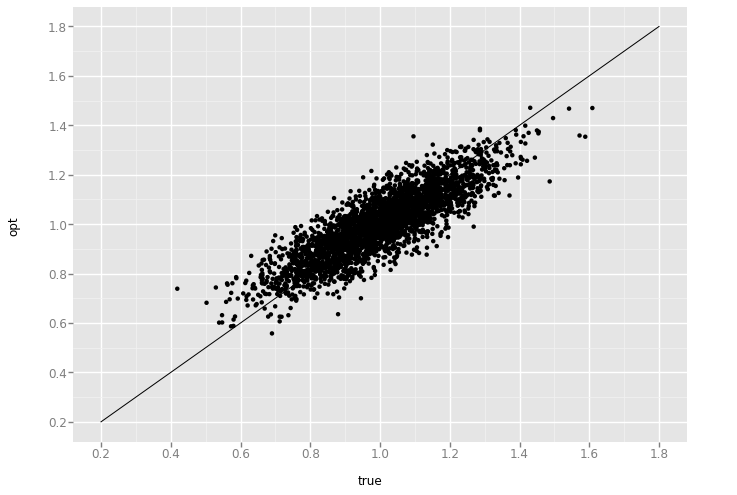

<ggplot: (8735909086929)>


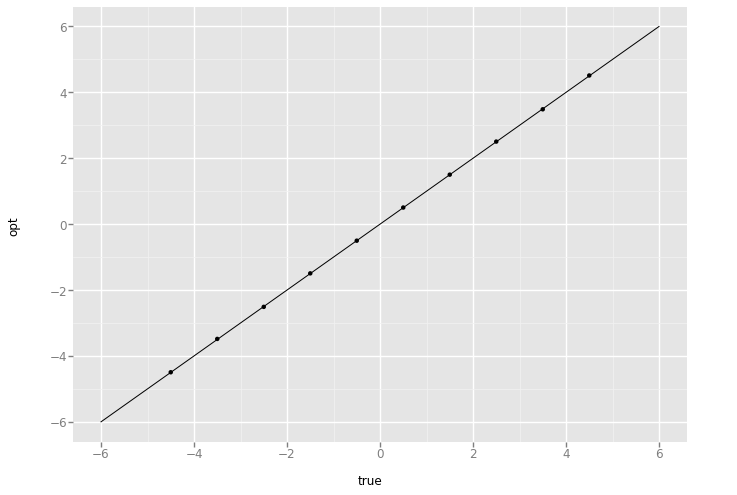

<ggplot: (8735907257241)>


In [52]:
# print(glmm_par_opt)
print '--------------- beta:\n'
print true_beta
print lmm_par_opt['beta'].e()

print '--------------- mu:\n'
print lmm_par_opt['mu'].e()[0]
print true_mu

print '--------------- mu info:\n'
print lmm_par_opt['mu_info'].e()[0]
print true_mu_info

print '--------------- y info:\n'
print lmm_par_opt['y_info'].e()[0]
print true_y_info


# Check the random effect estimates.  This requires simulated data.
from ggplot import *
import pandas as pd
%matplotlib inline

if sufficient:
    plot_df = pd.DataFrame({ 'opt': lmm_par_opt['u'].e(), 'true': true_u_sufficient })
else:
    plot_df = pd.DataFrame({ 'opt': lmm_par_opt['u'].e(), 'true': true_u_ancillary })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)

plot_df = pd.DataFrame({ 'opt': lmm_par_opt['beta'].e(), 'true': true_beta })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)


--------------- mu:

1.00132319351
[ 1.00131359]
--------------- mu info:

38.4837275725
[ 38.32955386]
--------------- y info:

1.00121987618
[ 1.00124673]


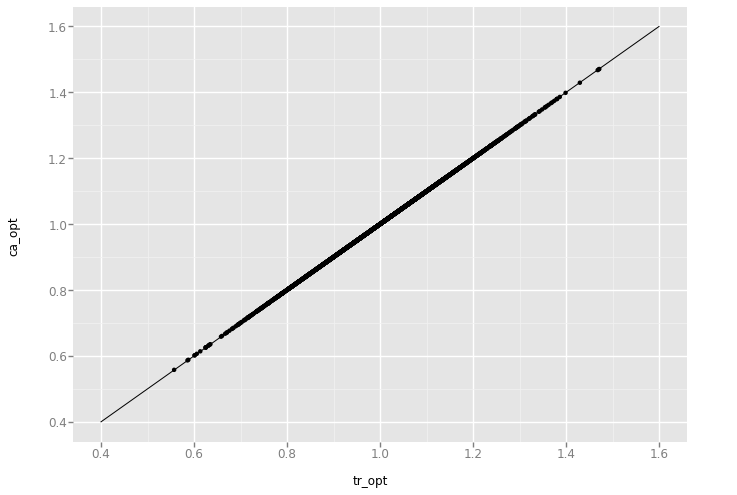

<ggplot: (8735907026505)>


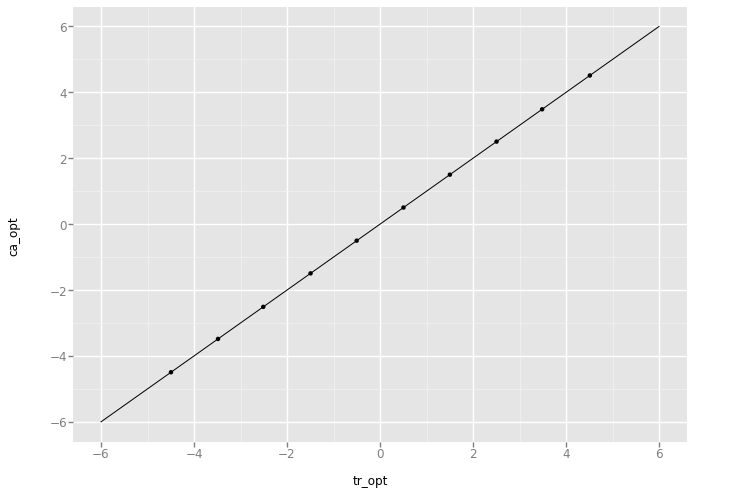

<ggplot: (8735909052505)>


In [53]:
# print(glmm_par_opt)

print '--------------- mu:\n'
print ca_moment_par_opt['e_mu'].get()
print moment_par_opt['e_mu'].get()

print '--------------- mu info:\n'
print ca_moment_par_opt['e_mu_info'].get()
print moment_par_opt['e_mu_info'].get()

print '--------------- y info:\n'
print ca_moment_par_opt['e_y_info'].get()
print moment_par_opt['e_y_info'].get()


plot_df = pd.DataFrame({ 'tr_opt': moment_par_opt['e_u'].get(), 'ca_opt': ca_moment_par_opt['e_u'].get() })
print ggplot(plot_df, aes(x='tr_opt', y='ca_opt')) + geom_point() + geom_abline(slope=1, intercept=0)

plot_df = pd.DataFrame({ 'tr_opt': moment_par_opt['e_beta'].get(), 'ca_opt': ca_moment_par_opt['e_beta'].get() })
print ggplot(plot_df, aes(x='tr_opt', y='ca_opt')) + geom_point() + geom_abline(slope=1, intercept=0)


In [50]:
# They seem to differ slightly in the u variance and uncertainty parameters.

print moment_par_opt['e_mu_info']
print ca_moment_par_opt['e_mu_info']

print moment_par_opt['e_log_mu_info']
print ca_moment_par_opt['e_log_mu_info']

diffs = moment_par_opt.get_vector() - ca_moment_par_opt.get_vector()
print np.where(np.abs(diffs) > 1e-3)
print moment_indices

# plot_df = pd.DataFrame({ 'tr_opt': moment_par_opt['e_beta_outer'].get(), 'ca_opt': ca_moment_par_opt['e_beta_outer'].get() })
# print ggplot(plot_df, aes(x='tr_opt', y='ca_opt')) + geom_point() + geom_abline(slope=1, intercept=0)


e_mu_info: [ 38.32955386]
e_mu_info: 38.4837275725
e_log_mu_info: [ 3.64586431]
e_log_mu_info: 3.64990216557
(array([  67,   68, 3142, 3203, 3241, 3304, 3319, 3399, 3520, 3554, 3569,
       3668, 3713, 3756, 3789, 3850, 3858, 3894, 4029, 4069, 4090, 4266,
       4290, 4347, 4356, 4378, 4472, 4531, 4573, 4800, 4811, 4827, 4875,
       5009, 5201, 5206, 5309, 5316, 5375, 5415, 5498, 5778, 5829, 5856,
       5901, 5937, 6004, 6036]),)
Moment Parameters:
	e_beta:
[0 1 2 3 4 5 6 7 8 9]
	e_beta_outer:
[[ 10.  11.  13.  16.  20.  25.  31.  38.  46.  55.]
 [ 11.  12.  14.  17.  21.  26.  32.  39.  47.  56.]
 [ 13.  14.  15.  18.  22.  27.  33.  40.  48.  57.]
 [ 16.  17.  18.  19.  23.  28.  34.  41.  49.  58.]
 [ 20.  21.  22.  23.  24.  29.  35.  42.  50.  59.]
 [ 25.  26.  27.  28.  29.  30.  36.  43.  51.  60.]
 [ 31.  32.  33.  34.  35.  36.  37.  44.  52.  61.]
 [ 38.  39.  40.  41.  42.  43.  44.  45.  53.  62.]
 [ 46.  47.  48.  49.  50.  51.  52.  53.  54.  63.]
 [ 55.  56.  57.  58. 

In [17]:
# # Slow, but probably faster than using CG if you want the covariance of many parameters.
# hess_time = time.time()
# print 'Calculating KL Hessian...'
# kl_hess = kl_wrapper.kl_hess(vb_opt.x)
# hess_time =  time.time() - hess_time
# elbo_hess = -kl_hess
# print 'Done.'

# print 'Hessian time (seconds): %f' % hess_time

In [18]:
# hess_norm = np.sqrt(np.sum(kl_hess**2))
# diag_norm = np.sqrt(np.sum(np.diag(kl_hess)**2))

# # How diagonal is the Hessian?
# print 'Proportion of the frobenius norm off the diagonal:'
# print (hess_norm - diag_norm) / hess_norm